# Economic Convergence and the Great Recession

I recently came across an interesting [article](https://www.cgdev.org/blog/everything-you-know-about-cross-country-convergence-now-wrong) that offers a glimmer of hope when it comes to economic convergence between countries.  The article included an interesting visualization of beta coefficients, but I wanted to make a few changes to see if the results still hold: 

1. [First, I visualized the entire time series through 2016 rather than stopping at 2000](#Visualizing-the-Full-Time-Series).
2. [Next, I excluded post-2006 data to avoid the effects of the financial crisis](#Excluding-Post-2006-Data).   

The patterns the authors describe are still present but less convincing after these changes.  

In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [31]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [32]:
#Helper function for viewing df
def ends(df, x=5):
    fill = ['...' for i in range(len(df.columns))]
    fill_df = pd.DataFrame([fill], columns=list(df))
    return df.head(x).append(fill_df).append(df.tail(x))

# Loading the Data

Below, I try do reproduce [their Stata code](https://www.dropbox.com/sh/eu5sob3hs56oymg/AAALaoQOCPt--3u1fQaHMihua?dl=0) in Python.   

In [33]:
# Load Maddison data:
# https://www.rug.nl/ggdc/historicaldevelopment/maddison/
# Maddison Project Database, version 2018. Bolt, Jutta, Robert Inklaar, 
# Herman de Jong and Jan Luiten van Zanden (2018), “Rebasing ‘Maddison’: 
# new income comparisons and the shape of long-run economic development”, 
# Maddison Project Working paper 10
md_df = pd.read_stata('inputs/mpd2018.dta')
md_df.drop(['i_cig', 'i_bm', 'rgdpnapc'], axis=1, inplace=True)

# Exclude dates earlier than 1950, remove former countries:
# Puerto Rico, Former USSR, Czechoslovakia, Former Yugoslavia
md_df = md_df[(md_df['year'] >= 1950) &
    (~md_df['countrycode'].isin(["PRI", "SUN", "CSK", "YUG"]))]

# Note, it's just pop, not mad_pop as in '01 Prepare Data.do'
md_df['pop'] = md_df['pop']/1000
md_df.rename({'countrycode': 'ccode', 'cgdppc':'gdp'}, axis=1, inplace=True)

# IMF Oil producers 
# (http://datahelp.imf.org/knowledgebase/articles/516096-which-countries-comprise-export-earnings-fuel-a:
oil = ["DZA", "AGO", "AZE", "BHR", "BRN", "TCD", "COG", "ECU", "GNQ", 
       "GAB", "IRN", "IRQ", "KAZ", "KWT", "NGA", "OMN", "QAT", "RUS", 
       "SAU", "TTO", "TKM", "ARE", "VEN", "YEM", "LBY", "TLS", "SDN"]

# Remove oil and small countries
md_df = md_df[(md_df['pop'] > 1) & 
    (~md_df['ccode'].isin(oil))]

ends(md_df, 10)

,ccode,country,year,gdp,pop
3,AFG,Afghanistan,1950,2392,8.15
4,AFG,Afghanistan,1951,2422,8.284
5,AFG,Afghanistan,1952,2462,8.425
6,AFG,Afghanistan,1953,2568,8.573
7,AFG,Afghanistan,1954,2576,8.728
8,AFG,Afghanistan,1955,2579,8.891
9,AFG,Afghanistan,1956,2644,9.062
10,AFG,Afghanistan,1957,2593,9.241
11,AFG,Afghanistan,1958,2684,9.429
12,AFG,Afghanistan,1959,2705,9.625


In [34]:
# World Bank World Development Indicators
# http://databank.worldbank.org/data/source/world-development-indicators
wdi_df = pd.read_csv('inputs/wdi_data.csv')

cols = list(wdi_df)[4:]
years = [str(i) for i in range(1960, 2018)]
renames = dict(zip(cols, years))
wdi_df.rename(columns=renames, inplace=True)
wdi_df.rename(columns={'Country Name': 'country', 
    'Country Code':'ccode' }, inplace=True)
wdi_df = pd.melt(wdi_df, id_vars=['country', 'ccode', 'Series Name'], 
    value_vars=years, var_name='year', value_name='value') \
    .sort_values(by=['country', 'year'], ascending=True)

temp1_df = wdi_df[wdi_df['Series Name'] == 'GDP per capita (constant 2010 US$)'].copy()
temp1_df.rename(columns={'value': 'gdp'}, inplace=True)
temp2_df = wdi_df[wdi_df['Series Name'] == 'Population, total'].copy()
temp2_df.rename(columns={'value': 'pop'}, inplace=True)
wdi_df = temp1_df.merge(temp2_df, on=['country', 'ccode', 'year'], how='inner')
columns = ['country', 'ccode', 'year', 'gdp', 'pop']
wdi_df = wdi_df[columns]

#Remove years without data? Does original extend growth backwards?
wdi_df = wdi_df[wdi_df['gdp'] != '..']
wdi_df[['year', 'gdp', 'pop']] = wdi_df[['year', 'gdp', 'pop']] \
    .apply(pd.to_numeric, errors='ignore')   
wdi_df['pop'] = wdi_df['pop']/1000000 #convert to millions

# Remove oil and small countries
wdi_df = wdi_df[(wdi_df['pop'] > 1) & 
    (~wdi_df['ccode'].isin(oil))]
    
ends(wdi_df,10)
# This data seems quite a bit different from others,
# is the issue that it's at 2010 PPP?

,country,ccode,year,gdp,pop
42,Afghanistan,AFG,2002,364.571,21.9799
43,Afghanistan,AFG,2003,376.759,23.0649
44,Afghanistan,AFG,2004,364.095,24.119
45,Afghanistan,AFG,2005,389.416,25.0708
46,Afghanistan,AFG,2006,397.986,25.8935
47,Afghanistan,AFG,2007,440.368,26.6168
48,Afghanistan,AFG,2008,444.95,27.294
49,Afghanistan,AFG,2009,524.824,28.0043
50,Afghanistan,AFG,2010,553.3,28.8032
51,Afghanistan,AFG,2011,569.233,29.7086


In [35]:
# Penn World Tables
# Source: https://www.rug.nl/ggdc/productivity/pwt/
pw_df = pd.read_stata('inputs/pwt90.dta')
pw_df = pw_df[['country', 'countrycode', 'year', 'pop', 'rgdpe']]
pw_df.rename({'countrycode':'ccode', 'pop':'pwt_pop', 'rgdpe': 'pwt'},
    axis='columns', inplace=True)
pw_df['pwt'] = pw_df['pwt']/pw_df['pwt_pop']
pw_df = pw_df[pd.notnull(pw_df['pwt'])] #Remove any NaN value rows
pw_df.rename({'pwt':'gdp'}, axis='columns', inplace=True)

# Remove former countries:
# Puerto Rico, Former USSR, Czechoslovakia, Former Yugoslavia
pw_df = pw_df[(~pw_df['ccode'].isin(["PRI", "SUN", "CSK", "YUG"]))]

# Remove oil and small countries
pw_df = pw_df[(pw_df['pwt_pop'] > 1) & 
    (~pw_df['ccode'].isin(oil))]

ends(pw_df, 10)

,country,ccode,year,pwt_pop,gdp
215,Albania,ALB,1970,2.1506,3345.64
216,Albania,ALB,1971,2.20204,3398.7
217,Albania,ALB,1972,2.25384,3454.17
218,Albania,ALB,1973,2.306,3510.07
219,Albania,ALB,1974,2.35847,3571.01
220,Albania,ALB,1975,2.41123,3633.95
221,Albania,ALB,1976,2.46434,3691.24
222,Albania,ALB,1977,2.51787,3768.36
223,Albania,ALB,1978,2.57184,3837.11
224,Albania,ALB,1979,2.62629,3874.42


In [36]:
def calculate_growth(year, endyear, df):
    '''Returns a dataframe with a log(start_gdp) column
    and a growth rate calculated by country between the specified
    year and the endyear.'''
    initial_df = df[(df['year'] == year)].copy()
    initial_df['start_gdp'] = initial_df['gdp']
    initial_df = initial_df[['ccode', 'start_gdp']]

    end_df = df[df['year'] == endyear].copy()
    end_df['end_gdp'] =  end_df['gdp']
    end_df = end_df[['ccode', 'end_gdp']]

    reg_df = initial_df.merge(end_df, on=['ccode'], how='inner')
    reg_df['growth_rate'] = (np.log(reg_df['end_gdp']/reg_df['start_gdp'])/(endyear-year))*100
    reg_df['log_start_gdp'] = np.log(reg_df['start_gdp'])
    
    return reg_df


def growth_betas(startyear, endyear, df):
    '''
    This function iterates through the years between startyear (inclusive) 
    and endyear (exclusive). It calculates the beta (slope) of the regression between 
    log(initial_gdp) and growth rate between the startyear and the endyear.  It returns a dataframe 
    with the yearly beta, and upper and lower bounds of the 95% confidence interval.  
    '''
    results = {}
    for year in range(startyear, endyear):
        reg_df = calculate_growth(year, endyear, df)
        # Using robust covariance type to match stata code.  Not sure what this means.
        # I think it protects from heteroskedasticity because high income countries are
        # more tightly grouped in regression.  
        # https://stackoverflow.com/questions/30553838/
        # getting-statsmodels-to-use-heteroskedasticity-corrected-standard-errors-in-coeff
        poly_1 = smf.ols(formula='growth_rate ~ 1 + log_start_gdp', 
                         missing='drop', data=reg_df).fit(cov_type='HC3')
        beta = poly_1.params.log_start_gdp
        conf = poly_1.conf_int().loc['log_start_gdp']
        results[year] = [beta, conf[0], conf[1]]
    
    columns = ['beta', 'lower', 'upper']
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=columns)
    results_df = results_df.reset_index()
    results_df.rename({'index':'year'}, axis="columns", inplace=True)
    return results_df

def vis_df(df):
    '''
    Takes a dataframe with year, beta, and 95% confidence interval columns
    and returns point and errorbar objects.  
    '''
    # Generate points
    points = alt.Chart(df).mark_point(filled=True, size=50).encode(
        alt.X("year",
              scale=alt.Scale(zero=False),  #domain=(0,6)
              axis=alt.Axis(title='year', format='.0f')
        ),
        y=alt.Y('beta',
                scale=alt.Scale(zero=False),  #domain=(10, 11)
                axis=alt.Axis(title="beta")),
        color='source'
    ).properties(
        width=700,
        height=500
    )

    # Generate the error bars
    errorbars = alt.Chart(df).mark_rule().encode(
        x=alt.X("year"),
        y="lower",
        y2="upper", 
        color='source'
    )
    return points, errorbars 

# Visualizing the Full Time Series

First, I think it provides useful context to plot the GDP per capita over time for a few key countries.  This highlights the massive differences between economies, and the large gap quickly growing yet lower income countries have to make up.

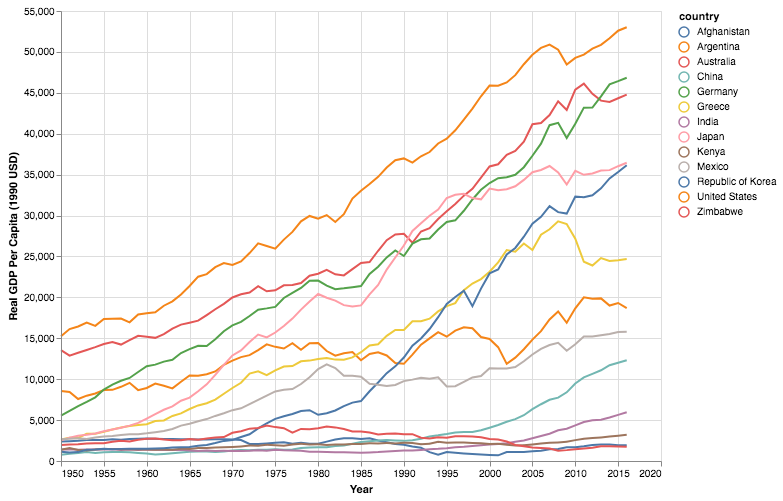

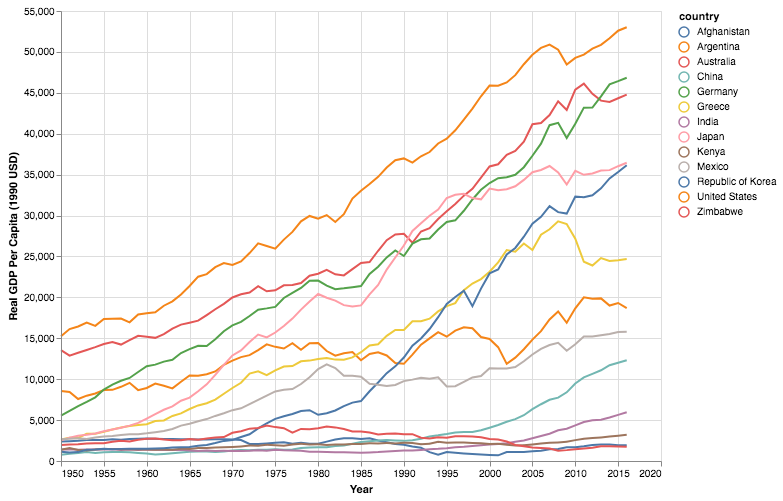

In [37]:
plot_df = md_df.copy()

countries=['United States', 'China', 'India', 'Zimbabwe', 
    'Afghanistan', 'Australia', 'Germany', 'Vietnam', 
    'Japan', 'Mexico', 'Argentina', 'Kenya', 'Republic of Korea', 
    'Greece']
plot_df = plot_df[plot_df['country'].isin(countries)]

lines = alt.Chart(plot_df).mark_line().encode(
    alt.X("year",
          #scale=alt.Scale(domain=(0,6)),
          scale=alt.Scale(zero=False),
          axis=alt.Axis(title='Year', format='d')
    ),
    y=alt.Y('gdp',
            #scale=alt.Scale(domain=(5, 11)),   #domain=(10, 11) zero=True
            axis=alt.Axis(title="Real GDP Per Capita (1990 USD)")),
    color='country'
).properties(
    width=600,
    height=450
)

lines

In [38]:
#Maddison years
mdres_df = growth_betas(1950, 2016, md_df)
mdres_df['source'] = 'MAD'
mdres_df

,year,beta,lower,upper,source
0,1950,0.170690,-0.094684,0.436065,MAD
1,1951,0.177727,-0.082038,0.437492,MAD
2,1952,0.123381,-0.139984,0.386745,MAD
3,1953,0.139078,-0.120965,0.399120,MAD
4,1954,0.110435,-0.154557,0.375427,MAD
5,1955,0.136332,-0.119595,0.392258,MAD
6,1956,0.116380,-0.145010,0.377770,MAD
7,1957,0.123253,-0.132235,0.378741,MAD
8,1958,0.171330,-0.086775,0.429436,MAD
9,1959,0.188515,-0.068639,0.445669,MAD


In [39]:
#Maddison years
wdires_df = growth_betas(1960, 2016, wdi_df)
wdires_df['source'] = 'WDI'
wdires_df

,year,beta,lower,upper,source
0,1960,0.124475,-0.121654,0.370604,WDI
1,1961,0.083666,-0.186202,0.353535,WDI
2,1962,0.075254,-0.208295,0.358802,WDI
3,1963,0.074899,-0.201301,0.351099,WDI
4,1964,0.064397,-0.202095,0.330890,WDI
5,1965,0.059432,-0.196024,0.314888,WDI
6,1966,0.054968,-0.198604,0.308539,WDI
7,1967,0.039630,-0.219888,0.299148,WDI
8,1968,0.030191,-0.236295,0.296678,WDI
9,1969,0.010394,-0.238415,0.259204,WDI


In [40]:
#Penn World Tables years
pwres_df = growth_betas(1960, 2014, pw_df)
pwres_df['source'] = 'PWT'
pwres_df

,year,beta,lower,upper,source
0,1960,0.154523,-0.117919,0.426964,PWT
1,1961,0.146803,-0.115250,0.408855,PWT
2,1962,0.053068,-0.264026,0.370162,PWT
3,1963,0.063741,-0.244830,0.372312,PWT
4,1964,0.074523,-0.251666,0.400711,PWT
5,1965,0.075464,-0.254498,0.405426,PWT
6,1966,0.073584,-0.256103,0.403271,PWT
7,1967,0.067824,-0.282727,0.418376,PWT
8,1968,0.065995,-0.287096,0.419086,PWT
9,1969,0.052397,-0.290699,0.395493,PWT


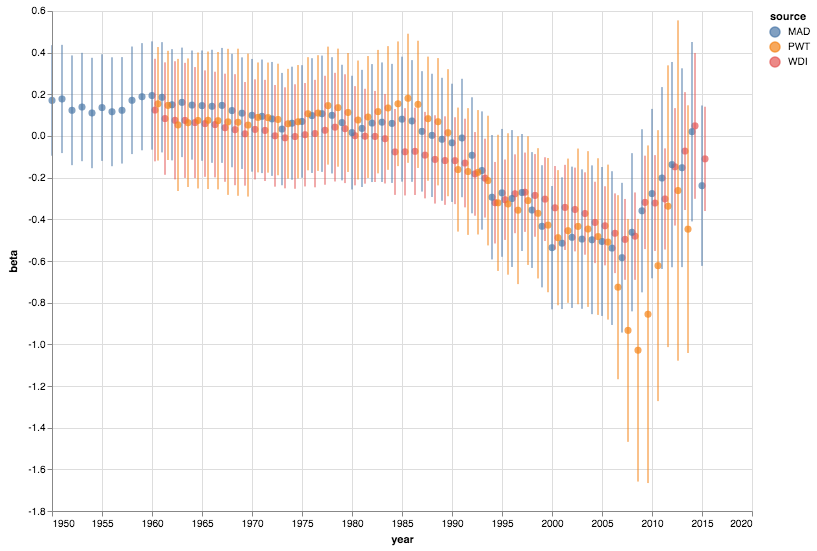

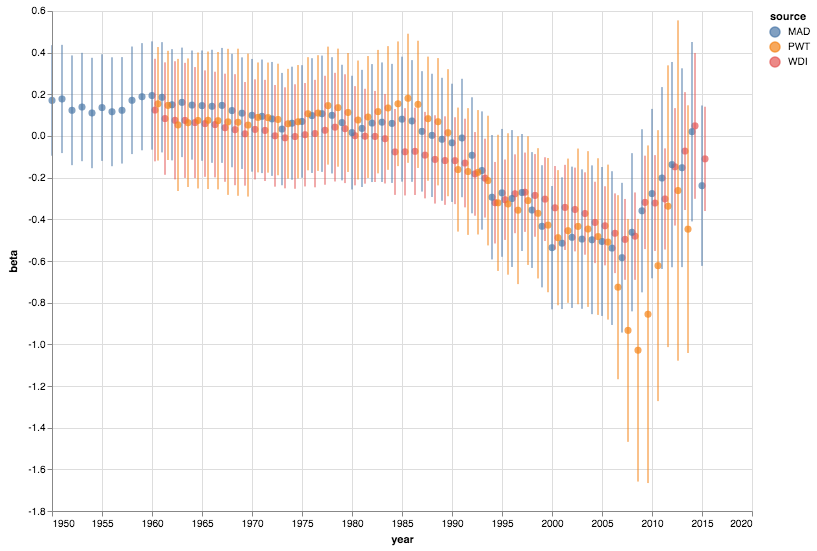

In [41]:
plot0_df = wdires_df.copy()
plot0_df['year'] = plot0_df['year'] + 0.3 #Stagger

plot1_df = mdres_df.copy()

plot2_df = pwres_df.copy()
plot2_df['year'] = plot2_df['year'] + 0.6 #Stagger

plot_df = pd.concat([plot0_df, plot1_df, plot2_df])
points, errors = vis_df(plot_df)
points + errors

# Excluding Post-2006 Data

In [42]:
#Maddison, using 2006 as the endpoint
mdres2007_df = growth_betas(1950, 2007, md_df)
mdres2007_df

,year,beta,lower,upper
0,1950,0.392257,0.117136,0.667377
1,1951,0.392761,0.125268,0.660255
2,1952,0.344445,0.068516,0.620375
3,1953,0.382201,0.108612,0.655790
4,1954,0.357408,0.079092,0.635724
5,1955,0.388786,0.121503,0.656069
6,1956,0.374378,0.097722,0.651035
7,1957,0.385073,0.116860,0.653286
8,1958,0.438621,0.170000,0.707242
9,1959,0.462846,0.195998,0.729694


In [43]:
#World Development Indicator, using 2006 as the endpoint
wdires2007_df = growth_betas(1960, 2007, wdi_df)
wdires2007_df

,year,beta,lower,upper
0,1960,0.295872,0.039029,0.552716
1,1961,0.253339,-0.031459,0.538137
2,1962,0.245760,-0.055153,0.546673
3,1963,0.247689,-0.044793,0.540170
4,1964,0.238355,-0.042430,0.519141
5,1965,0.235595,-0.032777,0.503967
6,1966,0.233399,-0.032411,0.499208
7,1967,0.213480,-0.060200,0.487161
8,1968,0.205349,-0.077671,0.488369
9,1969,0.181956,-0.081894,0.445806


In [44]:
#Penn World Tables, using 2006 as the endpoint:
pwres2007_df = growth_betas(1960, 2007, pw_df)
pwres2007_df

,year,beta,lower,upper
0,1960,0.369285,0.070320,0.668250
1,1961,0.365616,0.075939,0.655293
2,1962,0.278360,-0.051855,0.608575
3,1963,0.293380,-0.026399,0.613159
4,1964,0.315801,-0.027543,0.659144
5,1965,0.324183,-0.023984,0.672349
6,1966,0.323578,-0.023194,0.670351
7,1967,0.323843,-0.045890,0.693577
8,1968,0.331599,-0.041433,0.704631
9,1969,0.311122,-0.050523,0.672768


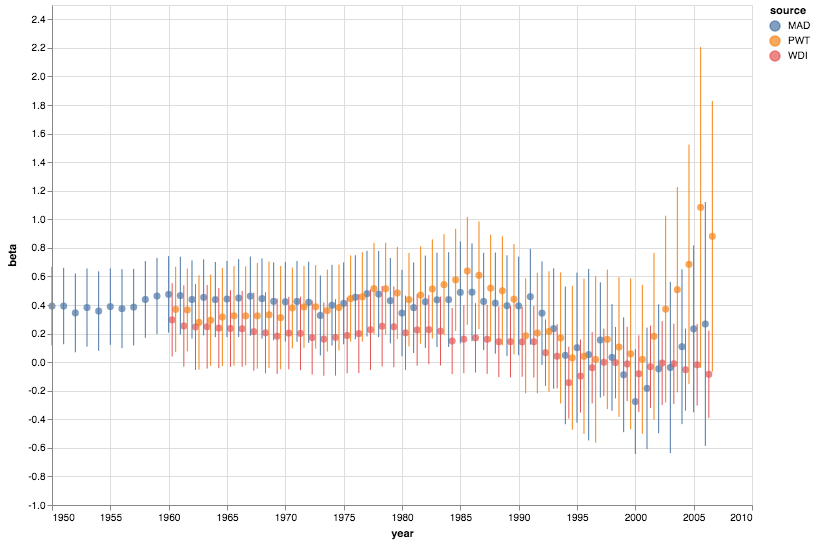

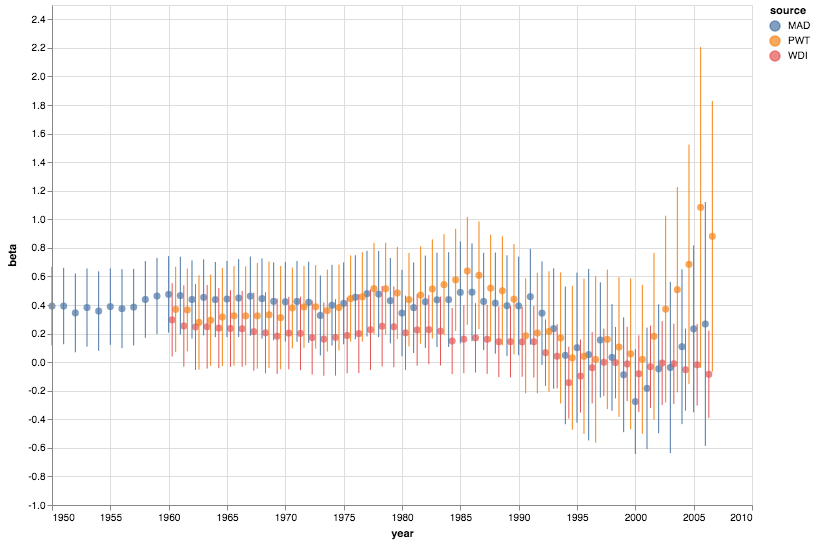

In [45]:
plot3_df = mdres2007_df.copy()
plot3_df['source'] = 'MAD'

plot4_df = pwres2007_df.copy()
plot4_df['year'] = plot4_df['year'] + 0.6 #Stagger
plot4_df['source'] = 'PWT'

plot5_df = wdires2007_df.copy()
plot5_df['year'] = plot5_df['year'] + 0.3 #Stagger
plot5_df['source'] = 'WDI'

plot_df = pd.concat([plot3_df, plot4_df, plot5_df])
points, errors = vis_df(plot_df)
points + errors

# Recession or acceleration?

A negative beta could be driven by a few things:

1. Slower growth in rich countries.  
2. Higher growth in poor countries.    
3. A combination of both.  

So what's the main driver?  Below, I first show a scatterplot to get a better view of the data.  Next, I bin the scatterplot by initial GDP to show that #3 (a combination of both) seems to be the answer, although the main driver seems to be higher growth in low and medium income countries.   

In [46]:
cols = ['ccode', 'source', 'year', 'start_gdp', 'growth_rate', 'log_start_gdp', 'predict']
growth_df = pd.DataFrame(columns=cols)

years = [1970, 1980, 1990, 2000, 2010]
for year in years:
    temp_df = calculate_growth(year, 2016, md_df)
    temp_df['year'] = year
    temp_df['source'] = 'MAD'
    poly = smf.ols(formula='growth_rate ~ 1 + log_start_gdp', 
                 missing='drop', data=temp_df).fit(cov_type='HC3')
    temp_df['predict'] = poly.predict(temp_df['log_start_gdp'])
    temp_df = temp_df[cols]
    growth_df = pd.concat([growth_df, temp_df])
    

growth_df

,ccode,source,year,start_gdp,growth_rate,log_start_gdp,predict
0,AFG,MAD,1970,2632.0,-0.675527,7.875499,1.970113
1,ALB,MAD,1970,2957.0,2.911520,7.991930,1.981668
2,ARG,MAD,1970,12259.0,0.917382,9.414016,2.122808
3,ARM,MAD,1970,NaN,NaN,NaN,NaN
4,AUS,MAD,1970,19990.0,1.753471,9.902987,2.171338
5,AUT,MAD,1970,13523.0,2.614115,9.512147,2.132548
6,BDI,MAD,1970,1067.0,-0.941348,6.972606,1.880502
7,BEL,MAD,1970,15724.0,2.015204,9.662944,2.147514
8,BEN,MAD,1970,1752.0,0.461140,7.468513,1.929720
9,BFA,MAD,1970,1865.0,-0.386814,7.531016,1.935923


In [47]:
# plot_df = pd.concat([plot6_df, plot7_df, plot8_df])
def scatter(df):
    points = alt.Chart(df).mark_point(filled=True, size=50).encode(
        alt.X("log_start_gdp",
              #scale=alt.Scale(domain=(0,6)),
              scale=alt.Scale(zero=False),
              axis=alt.Axis(title='log(starting_gdp)')
        ),
        y=alt.Y('growth_rate',
                scale=alt.Scale(zero=False),   #domain=(10, 11)
                axis=alt.Axis(title="Growth Rate")),
        color='year:O',  #:N for distinct colors, https://altair-viz.github.io/user_guide/encoding.html
    ).properties(
        width=550,
        height=400
    )

    lines = alt.Chart(df).mark_line().encode(
        x='log_start_gdp',
        y='predict',
        color='year:O', 
    )
    return points, lines

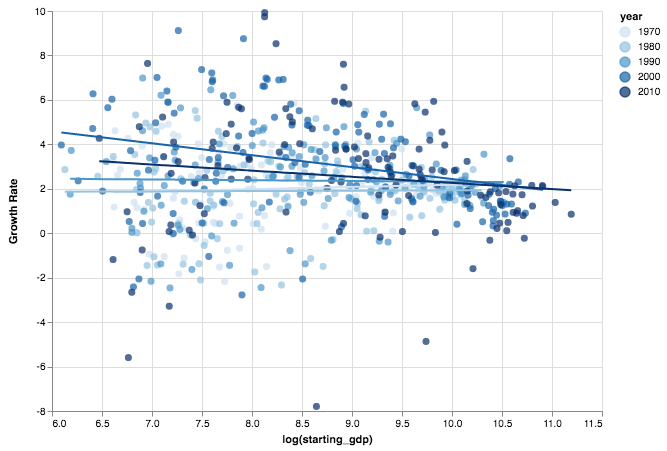

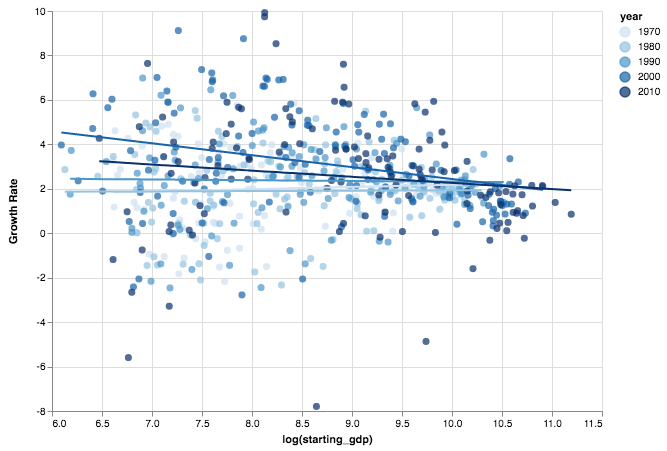

In [48]:
#Maddison
plot_df = growth_df[growth_df['source'] == 'MAD'].copy()
points, lines = scatter(plot_df)
points + lines

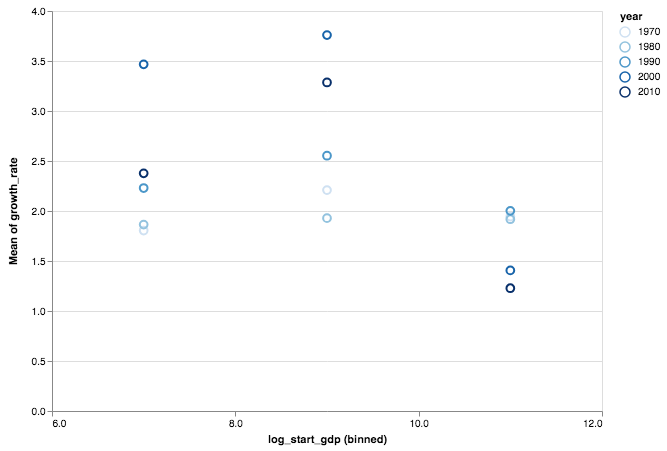

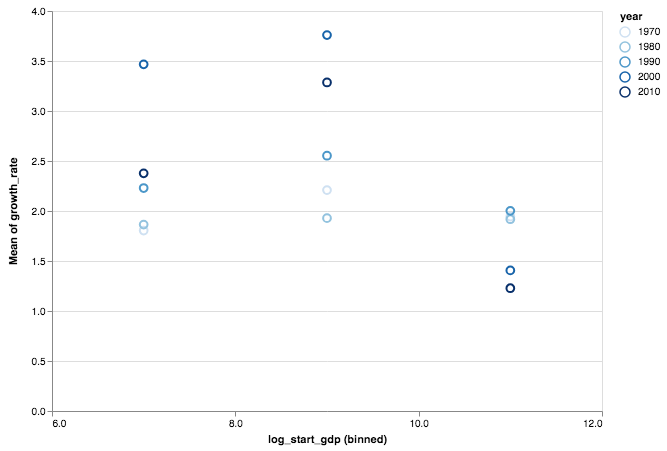

In [49]:
# Penn World Tables Binned
#Kind of misleading, because countries are moving between bins.  E.g. there are very few 
#countries in the 10-11 bin to begin with, so use larger bins, 3 total.  
plot_df = growth_df[growth_df['source'] == 'MAD'].copy()

points = alt.Chart(plot_df).mark_point(size=60).encode(
    alt.X("log_start_gdp:Q", bin=alt.Bin(maxbins=3)),
    y='mean(growth_rate)',
    color='year:O'
).properties(
    width=550,
    height=400
)

points

# References

*Everything You Know about Cross-Country Convergence Is (Now) Wrong*.  Dev Patel, Justin Sandefur and Arvind Subramanian. [https://www.cgdev.org/blog/everything-you-know-about-cross-country-convergence-now-wrong](https://www.cgdev.org/blog/everything-you-know-about-cross-country-convergence-now-wrong)